<a href="https://colab.research.google.com/github/Koosmaster/Tutorial-Automatic-Modulation-Classification/blob/main/V3_Draft_AMC_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: RF Signal Classification Using Deep Learning Models for Modulation Recognition

**by Markus Parrish**  
*updated: 2025-10-17*

---

## Project Overview
This project presents the development and evaluation of machine learning models for identification of radio frequency (RF) signals by focusing on Automatic Modulation Classification (AMC). The tutorial presents baseline models will include k-Nearest Neighbors (kNN), Support Vector Machines (SVM), and Random Forests. Deep learning methods will include Convolutional Neural Networks (CNNs), Recurrent Neural Networks (RNNs), and combinations of the prior. The dataset will be RadioML 2016.01A to enable a comparison across Signal-To-Noise Ratio (SNR) levels. It will provide reproducible code and highlight the limitations and benefits of each method.

- **Baseline Models:** k-Nearest Neighbors (kNN), Support Vector Machines (SVM), Random Forests  
- **Deep Learning Models:** Convolutional Neural Networks (CNN), Recurrent Neural Networks (RNN), and Hybrid CNN+RNN  
- **Dataset:** RadioML 2016.10A  
- **Objective:** Compare performance across varying Signal-to-Noise Ratio (SNR) levels and highlight the benefits and limitations of each method.  



## Learning Objectives

- Understand the problem context and dataset.
- Set up the Python environment reproducibly.
- Walk through data ingestion, processing, modeling/evaluation.

## Table of Contents

- [Tutorial: RF Signal Classification Using Deep Learning Models for Modulation Recognition](#tutorial-rf-signal-classification-using-deep-learning-models-for-modulation-recognition)
  - [Setup]($setup)
  - [Dataset](#dataset)
  - [Data Exploration](#data-exploration)
  - [Data Preprocessing](#data-preprocessing)
  - [Baseline Models (kNN, SVM, Random Forest)](#baseline-models-knn-svm-random-forest)
  - [CNN Model](#cnn-model)
  - [RNN Model (LSTM)](#rnn-model)

## Prerequisites & Setup

- Python 3.9+ is recommended (this tutorial was tested with Python 3.12).
- Ensure required libraries are installed: numpy, pandas, matplotlib, seaborn, scikit-learn, torch, tensorflow (for Keras), and utility libraries like pickle and h5py.

- If running in Google Colab, enable GPU acceleration for training deep models, and mount Google Drive or upload the dataset.

- It’s good practice to use a virtual environment and install dependencies via a requirements.txt for reproducibility.

In [3]:
# Environment check & dependency install
import sys, platform
print(f"Python: {sys.version.split()[0]}  |  Platform: {platform.platform()}")

# Uncomment to install from requirements.txt if running locally
# %pip install -q -r requirements.txt

Python: 3.12.12  |  Platform: Linux-6.6.105+-x86_64-with-glibc2.35


---

## Setup
Steps to prepare the Colab environment:
1. Enable GPU acceleration  
2. Import required libraries (NumPy, Pandas, Matplotlib, Seaborn, h5py, scikit-learn, PyTorch)  
3. Mount Google Drive or upload the dataset  
4. Verify imports and environment  

---


In [4]:
# Mount Google Drive (or configure to where dataset is located)
from google.colab import drive
drive.mount('/content/drive')

# Path to dataset (adjust this path to where the data file is located)
data_path = '/content/drive/MyDrive/AMC_datasets/RadioML2016_10A_dataset.pkl'


Mounted at /content/drive


In [5]:
# --- Libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, os, warnings
import random
import matplotlib.animation as animation
from IPython.display import HTML

# Scikit-learn for classical models and metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Deep learning libraries (PyTorch and Keras)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout, Reshape, Flatten



## Dataset
- **Source:** RadioML 2016.10A (DeepSig)  
- **Format:** Pickle file (`.pkl`) containing I/Q signal samples  
- **Classes:** 11 modulation types (8 digital, 3 analog)  
- **SNR Range:** –20 dB to +18 dB (2 dB steps)  
- **Samples:** Each record has 128 complex I/Q samples  

---
SOURCE: https://www.kaggle.com/code/ahmedali30/knndtamc-amc-rml2016a-updated

In [6]:
def load_radioml_pkl_dataset(filepath, filter_analog=False):
    """
    Load the RadioML 2016.10A dataset from a pickle file.
    Optionally filters for analog modulations.
    Returns:
      - radioml_dict: dict with keys (modulation_str, SNR) and values as list of complex signals.
      - unique_mods: list of unique modulation labels retained.
      - unique_snrs: list of unique SNR values retained.
    """
    print(f"Loading RadioML 2016.10A dataset from: {filepath}")
    with open(filepath, 'rb') as f:
        # The data was pickled in Python2, so specify encoding for compatibility
        data_dict = pickle.load(f, encoding='latin1')

    radioml_dict = {}
    # Map raw analog labels to simplified labels
    analog_mod_map = {
        'AM-DSB': 'AM',    # Double Sideband AM
        'AM-SSB': 'AM',    # Single Sideband AM (map to AM)
        'WBFM':   'FM'     # Wideband FM (corrected from B-FM to WBFM)
    }
    all_mod_names = set()

    for (mod, snr), signals in data_dict.items():
        mod_str = mod if isinstance(mod, str) else mod.decode('utf-8', errors='ignore')
        all_mod_names.add(mod_str)

        process_signal = False
        if filter_analog:
            # Only process if it's an analog modulation in our map
            if mod_str in analog_mod_map:
                label = analog_mod_map.get(mod_str)
                process_signal = True
        else:
            # Process all modulations if not filtering
            label = mod_str # Use original modulation name
            process_signal = True

        if process_signal:
             # Convert I/Q data from separate I and Q arrays to complex
            # signals is of shape (num_examples, 2, num_samples)
            complex_signals = []
            for i in range(signals.shape[0]):
                # I channel is signals[i,0,:], Q channel is signals[i,1,:]
                complex_signal = signals[i, 0, :] + 1j * signals[i, 1, :]
                complex_signals.append(complex_signal)
            key = (label, snr)
            radioml_dict.setdefault(key, []).extend(complex_signals)


    unique_mods = sorted({k[0] for k in radioml_dict.keys()})
    unique_snrs = sorted({k[1] for k in radioml_dict.keys()})
    print(f"Found raw modulation types: {sorted(list(all_mod_names))}")
    print(f"Loaded dataset contains {len(unique_mods)} modulation classes and {len(unique_snrs)} SNR values.")
    for mod, snr in sorted(radioml_dict.keys()):
        print(f"  {mod} at {snr} dB : {len(radioml_dict[(mod,snr)])} samples")
    return radioml_dict, unique_mods, unique_snrs

# Load the full dataset
radioml_data, mod_classes, snr_values = load_radioml_pkl_dataset(data_path, filter_analog=False)

Loading RadioML 2016.10A dataset from: /content/drive/MyDrive/AMC_datasets/RadioML2016_10A_dataset.pkl
Found raw modulation types: ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
Loaded dataset contains 11 modulation classes and 20 SNR values.
  8PSK at -20 dB : 1000 samples
  8PSK at -18 dB : 1000 samples
  8PSK at -16 dB : 1000 samples
  8PSK at -14 dB : 1000 samples
  8PSK at -12 dB : 1000 samples
  8PSK at -10 dB : 1000 samples
  8PSK at -8 dB : 1000 samples
  8PSK at -6 dB : 1000 samples
  8PSK at -4 dB : 1000 samples
  8PSK at -2 dB : 1000 samples
  8PSK at 0 dB : 1000 samples
  8PSK at 2 dB : 1000 samples
  8PSK at 4 dB : 1000 samples
  8PSK at 6 dB : 1000 samples
  8PSK at 8 dB : 1000 samples
  8PSK at 10 dB : 1000 samples
  8PSK at 12 dB : 1000 samples
  8PSK at 14 dB : 1000 samples
  8PSK at 16 dB : 1000 samples
  8PSK at 18 dB : 1000 samples
  AM-DSB at -20 dB : 1000 samples
  AM-DSB at -18 dB : 1000 samples
  AM-DSB at -16 dB 

In [7]:
# Convert the filtered data dictionary into arrays X (modulation scheme), y (labels), and snr_list
X = []
y = []
snr_list = []
for (mod, snr), signals in radioml_data.items():
    for complex_signal in signals:
        # Each complex signal is length N (e.g., 128 samples); split into I and Q components
        iq_matrix = np.vstack((complex_signal.real, complex_signal.imag))  # shape (2, N)
        X.append(iq_matrix)
        y.append(mod)   # mod is already a string label ('AM' or 'FM')
        snr_list.append(snr)
X = np.array(X)
y = np.array(y)
snr_list = np.array(snr_list)
print("X shape:", X.shape)
print("y shape:", y.shape)
print("snr_list shape:", snr_list.shape)
print("Unique modulations loaded:", mod_classes)
print("Unique SNRs loaded:", snr_values)


X shape: (220000, 2, 128)
y shape: (220000,)
snr_list shape: (220000,)
Unique modulations loaded: ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
Unique SNRs loaded: [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]



## Data Exploration
Goals:
- Inspect dataset structure  
- Plot example I/Q waveforms  
- Visualize modulation class distribution  
- Plot spectrograms and constellation diagrams  

---


In [8]:
# Check of class distribution
unique, counts = np.unique(y, return_counts=True)
class_dist = dict(zip(unique, counts))
print("Class distribution:", class_dist)


Class distribution: {np.str_('8PSK'): np.int64(20000), np.str_('AM-DSB'): np.int64(20000), np.str_('AM-SSB'): np.int64(20000), np.str_('BPSK'): np.int64(20000), np.str_('CPFSK'): np.int64(20000), np.str_('GFSK'): np.int64(20000), np.str_('PAM4'): np.int64(20000), np.str_('QAM16'): np.int64(20000), np.str_('QAM64'): np.int64(20000), np.str_('QPSK'): np.int64(20000), np.str_('WBFM'): np.int64(20000)}


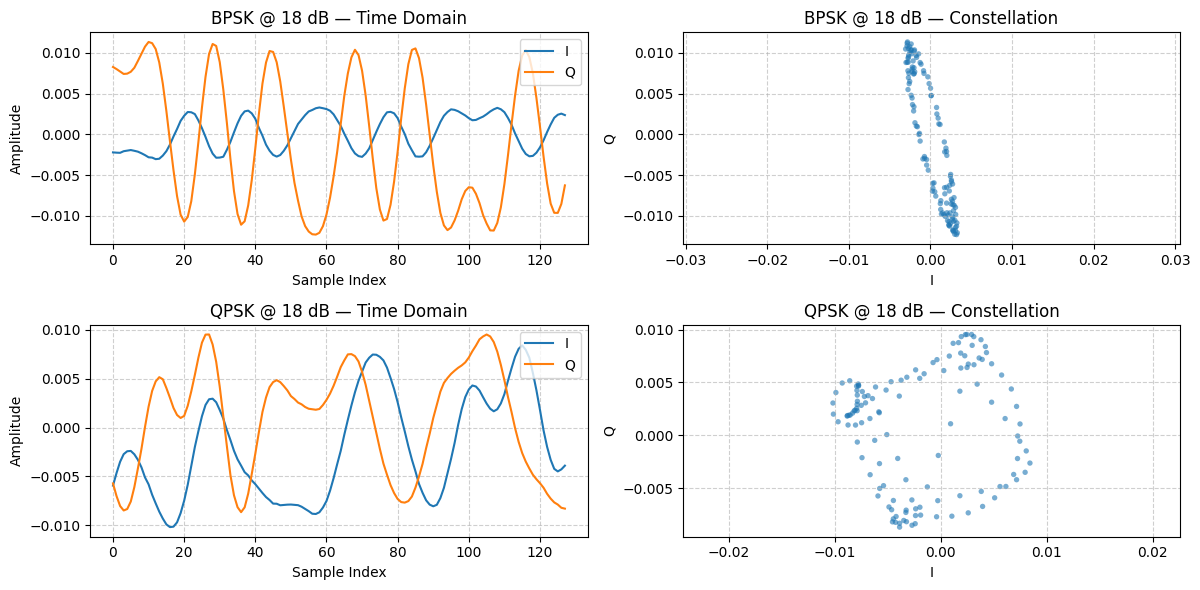

In [15]:
def visualize_modulations(data, mods=None, snr=18, num_samples=128): # Reduced num_samples to match RML2016.10A
    """
    Visualize one example of multiple modulation types at a fixed SNR.

    Parameters:
        data : dict
            Dictionary with keys (mod, snr) and values as arrays of signals.
        mods : list
            List of modulation types to show. If None, pick first 4 automatically.
        snr : int
            The SNR level to use for all mods.
        num_samples : int
            Number of time-domain samples to show.
    """
    # Pick modulations automatically if not provided
    if mods is None:
        # Decode keys if they are bytes and filter for analog modulations if needed
        all_mods_raw = sorted(set(m.decode('utf-8', errors='ignore') if isinstance(m, bytes) else m for m, _ in data.keys()))
        # Assuming you only want analog modulations as loaded previously
        analog_mods = [m for m in all_mods_raw if m in ['AM', 'FM']] # Filter for simplified analog mods
        mods = analog_mods[:4] # Take up to the first 4 analog mods if available


    n_mods = len(mods)
    if n_mods == 0:
        print("No analog modulations found in the dataset to visualize.")
        return

    fig, axs = plt.subplots(n_mods, 2, figsize=(12, 3*n_mods))
    # Adjust axs indexing for single row case
    if n_mods == 1:
        axs = axs.reshape(1, -1)


    for i, mod in enumerate(mods):
        # Find the actual keys in data dictionary that match the simplified mod and snr
        # The keys are tuples of (original_mod_bytes or str, snr)
        matching_keys = [k for k in data.keys() if (k[0].decode('utf-8', errors='ignore') if isinstance(k[0], bytes) else k[0]) == mod and k[1] == snr]

        if not matching_keys:
            print(f"Skipping visualization for {mod} at {snr} dB: not found in dataset with this key structure.")
            continue

        # Assume there is at least one matching key and pick the first one
        key = matching_keys[0]

        # Pick a random signal (which is a complex numpy array in radioml_data)
        signals_list = data[key]
        if not signals_list:
            print(f"No signals found for {mod} at {snr} dB.")
            continue
        sig_complex = random.choice(signals_list) # This is a 1D array of complex numbers

        # Extract I and Q components from the complex signal
        I = sig_complex.real
        Q = sig_complex.imag

        # --- Time-domain ---
        axs[i, 0].plot(I[:num_samples], label="I", color="tab:blue")
        axs[i, 0].plot(Q[:num_samples], label="Q", color="tab:orange")
        axs[i, 0].set_title(f"{mod} @ {snr} dB — Time Domain")
        axs[i, 0].set_xlabel("Sample Index")
        axs[i, 0].set_ylabel("Amplitude")
        axs[i, 0].legend(loc="upper right")
        axs[i, 0].grid(True, linestyle="--", alpha=0.6)

        # --- Constellation ---
        axs[i, 1].scatter(I, Q, alpha=0.6, s=15, color="tab:blue", edgecolor="none")
        axs[i, 1].set_title(f"{mod} @ {snr} dB — Constellation")
        axs[i, 1].set_xlabel("I")
        axs[i, 1].set_ylabel("Q")
        axs[i, 1].grid(True, linestyle="--", alpha=0.6)
        axs[i, 1].axis("equal")

    plt.tight_layout()
    plt.show()


# Example usage: show analog mods at SNR=10
# Use the correctly loaded data variable 'radioml_data'
visualize_modulations(radioml_data, mods=["BPSK", "QPSK"], snr=18) # Use analog modulations loaded

In [16]:
def animate_bpsk_decision(signal, key=None, interval=80, threshold=0.0, max_bits_show=32):
    """
    Animated BPSK constellation with decision regions and live bit decoding.
      - Left of I=0 => bit 0  (you can swap mapping if you prefer)
      - Right of I=0 => bit 1
    """
    # unpack & prep
    mod, snr = (key if key is not None else ("BPSK", ""))
    # Decode mod if it's bytes, handle if it's already str or np.str_
    mod = mod.decode('utf-8', errors='ignore') if isinstance(mod, bytes) else str(mod)

    # Ensure signal is a 2D array (channels, samples) if it's a complex 1D array
    if signal.ndim == 1 and np.iscomplexobj(signal):
        I, Q = signal.real, signal.imag
    elif signal.ndim == 2 and signal.shape[0] == 2:
        I, Q = signal[0], signal[1]
    else:
        print(f"Warning: Unexpected signal shape or type for {mod} at {snr} dB. Skipping animation.")
        return None # Return None if signal format is unexpected

    bits = (I >= threshold).astype(int)      # 1 where I>=0, else 0

    # figure/axes
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_aspect("equal")
    pad = 0.5
    # Adjust limits based on actual signal data
    ax.set_xlim(I.min()-pad, I.max()+pad)
    ax.set_ylim(Q.min()-pad, Q.max()+pad)
    ax.set_title(f"{mod} @ {snr} dB — Constellation Animation" if snr!="" else f"{mod} — Constellation Animation")
    ax.set_xlabel("I")
    ax.set_ylabel("Q")
    ax.grid(True, linestyle="--", alpha=0.6)

    # decision boundary + shaded regions (still show for context, though not BPSK)
    ax.axvline(threshold, linestyle="--", linewidth=1)
    ax.axvspan(ax.get_xlim()[0], threshold, alpha=0.08)   # region for bit 0 (I<th)
    ax.axvspan(threshold, ax.get_xlim()[1], alpha=0.08)   # region for bit 1 (I>=th)

    # static labels for regions (adjusting for non-BPSK context)
    yl = ax.get_ylim()
    xmid_left  = (ax.get_xlim()[0] + threshold) / 2
    xmid_right = (threshold + ax.get_xlim()[1]) / 2
    ax.text(xmid_left,  0.9*yl[1], "I < 0", ha="center", va="top")
    ax.text(xmid_right, 0.9*yl[1], "I >= 0", ha="center", va="top")


    # two scatters so we can color by bit (based on I>=threshold)
    scat0 = ax.scatter([], [], s=22, alpha=0.85)  # points where I < threshold
    scat1 = ax.scatter([], [], s=22, alpha=0.85)  # points where I >= threshold


    # live-decoded bit string display (adjusting for non-BPSK context)
    txt = ax.text(0.02, 0.02, "", transform=ax.transAxes, ha="left", va="bottom",
                  bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

    def init():
        scat0.set_offsets(np.empty((0,2)))
        scat1.set_offsets(np.empty((0,2)))
        txt.set_text("")
        return scat0, scat1, txt

    def update(f):
        # use first f samples
        I_f, Q_f, b_f = I[:f], Q[:f], bits[:f]
        # split by bit
        if f == 0:
            off0 = np.empty((0,2)); off1 = np.empty((0,2))
        else:
            mask0 = (b_f == 0)
            mask1 = ~mask0
            off0 = np.column_stack((I_f[mask0], Q_f[mask0])) if mask0.any() else np.empty((0,2))
            off1 = np.column_stack((I_f[mask1], Q_f[mask1])) if mask1.any() else np.empty((0,2))

        scat0.set_offsets(off0)
        scat1.set_offsets(off1)

        # show last few "decision" values as a string
        show = b_f[-max_bits_show:] if f>0 else []
        txt.set_text("I>=0 decisions: " + "".join(map(str, show)) if len(show) else "I>=0 decisions: ")
        return scat0, scat1, txt

    ani = animation.FuncAnimation(fig, update, frames=len(I), init_func=init,
                                  blit=True, interval=interval)
    plt.close(fig)
    return ani

# --- Example usage ---
# Use radioml_data which contains the loaded dataset
# Select an example key for a BPSK modulation (e.g., BPSK at 10 dB)
example_key = ('BPSK', 10) # Changed to BPSK
if example_key in radioml_data:
    mod_name = example_key[0]
    if mod_name == 'BPSK':
        # Select the first signal for this key
        example_signal_complex = radioml_data[example_key][0]
        # The animate_bpsk_decision function expects a complex 1D array or a (2,N) array
        # radioml_data stores lists of complex 1D arrays.
        # Pass the complex 1D array directly to the function
        ani = animate_bpsk_decision(example_signal_complex, example_key, interval=80, threshold=0.0)
        if ani:
            HTML(ani.to_jshtml())
    else:
        print(f"Animation is designed for BPSK and is not directly applicable to {mod_name}.")
else:
    print(f"Example key {example_key} not found in radioml_data. Cannot run animation.")

## Data Preprocessing

**Goal.** Make the data ready for classical ML (flat features) and DL (tensor inputs), explain split policy, and document normalization choices.

- **Labels.** We classify **modulation only**; SNR is used purely for analysis (per-SNR accuracy).
- **Shapes.** Each sample is `(2, 128)` representing I/Q over 128 time points.
- **Splits.** Stratified by modulation label, fixed random seed for reproducibility.
- **Scaling.** Classical models (kNN/SVM/RF) benefit from standardization on flattened features.
- **DL format.** PyTorch CNN expects `(batch, channels=2, length=128)`; LSTM expects `(batch, seq_len=128, features=2)`.


In [17]:
# Split data into train and test sets
SEED = 42  # for reproducibility
X_train, X_test, y_train, y_test, snr_train, snr_test = train_test_split(
    X, y, snr_list, test_size=0.25, random_state=SEED, stratify=y
)
print("Train set size:", X_train.shape, "| Test set size:", X_test.shape)
print("Train label distribution:", dict(zip(*np.unique(y_train, return_counts=True))))
print("Test label distribution:", dict(zip(*np.unique(y_test, return_counts=True))))


Train set size: (165000, 2, 128) | Test set size: (55000, 2, 128)
Train label distribution: {np.str_('8PSK'): np.int64(15000), np.str_('AM-DSB'): np.int64(15000), np.str_('AM-SSB'): np.int64(15000), np.str_('BPSK'): np.int64(15000), np.str_('CPFSK'): np.int64(15000), np.str_('GFSK'): np.int64(15000), np.str_('PAM4'): np.int64(15000), np.str_('QAM16'): np.int64(15000), np.str_('QAM64'): np.int64(15000), np.str_('QPSK'): np.int64(15000), np.str_('WBFM'): np.int64(15000)}
Test label distribution: {np.str_('8PSK'): np.int64(5000), np.str_('AM-DSB'): np.int64(5000), np.str_('AM-SSB'): np.int64(5000), np.str_('BPSK'): np.int64(5000), np.str_('CPFSK'): np.int64(5000), np.str_('GFSK'): np.int64(5000), np.str_('PAM4'): np.int64(5000), np.str_('QAM16'): np.int64(5000), np.str_('QAM64'): np.int64(5000), np.str_('QPSK'): np.int64(5000), np.str_('WBFM'): np.int64(5000)}


In [18]:
# Flatten the 2x256 I/Q matrices into 512-dim vectors for classical ML
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # shape (2250, 512)
X_test_flat  = X_test.reshape(X_test.shape[0], -1)    # shape (750, 512)

# Standardize the features (zero mean, unit variance)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)



## Baseline Models (kNN, SVM, Random Forest)
- Train and evaluate classical ML models  
- Measure accuracy, confusion matrices  
- Use as a benchmark against deep learning models  

---


In [60]:
# kNN: Explore different k values using cross-validation
k_values = [3, 5, 7, 9, 11]  # candidate neighbor counts
mean_cv_scores = []
print("Cross-validating kNN with different k values...")
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    cv_scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
    mean_score = np.mean(cv_scores)
    mean_cv_scores.append(mean_score)
    print(f"  k={k}: Mean CV Accuracy = {mean_score:.4f}")
best_k = k_values[np.argmax(mean_cv_scores)]
print(f"Best k based on CV: {best_k}")


Cross-validating kNN with different k values...
  k=3: Mean CV Accuracy = 0.3036
  k=5: Mean CV Accuracy = 0.3023
  k=7: Mean CV Accuracy = 0.2984
  k=9: Mean CV Accuracy = 0.2967
  k=11: Mean CV Accuracy = 0.2954
Best k based on CV: 3


In [61]:
# Encode y_train
y_train_encoded = label_encoder.transform(y_train).ravel()

# Re-train kNN on encoded labels
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train_scaled, y_train_encoded)

# Predict on test set
y_pred_knn = best_knn.predict(X_test_scaled)

# Accuracy
test_acc_knn = accuracy_score(y_test_encoded_flat, y_pred_knn)
print(f"kNN Test Accuracy (k={best_k}): {test_acc_knn:.3f}")


kNN Test Accuracy (k=3): 0.306


In [62]:
cm_knn = confusion_matrix(y_test, y_pred_knn, labels=mod_classes)
print("kNN Confusion Matrix:")
print(cm_knn)


kNN Confusion Matrix:
[[0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]]



## CNN Model
- Implement 1D CNN architecture in PyTorch  
- Train with cross-entropy loss and Adam optimizer  
- Track accuracy/loss curves over epochs  
- Evaluate on test set and visualize confusion matrix  
SOURCE: https://www.kaggle.com/code/mattiasgcross/cnn-tutorial-for-radioml2016#Create-the-convolutional-base
---



In [39]:
# Prepare data for CNN (transpose to shape: length x channels)
X_train_cnn = np.transpose(X_train, (0, 2, 1))  # shape: (2250, 256, 2)
X_test_cnn  = np.transpose(X_test, (0, 2, 1))   # shape: (750, 256, 2)

# Define a 1D CNN model using Keras
cnn_model = models.Sequential([
    # Reshape layer to ensure input shape is (256, 2)
    layers.Input(shape=(256, 2)),  # 256 time steps, 2 channels (I,Q)
    # Convolutional layers
    layers.Conv1D(filters=64, kernel_size=8, activation='relu', padding='same'),
    layers.Dropout(0.5),
    layers.Conv1D(filters=128, kernel_size=8, activation='relu', padding='same'),
    layers.Dropout(0.5),
    layers.Conv1D(filters=128, kernel_size=8, activation='relu', padding='same'),
    layers.Dropout(0.5),
    layers.Conv1D(filters=64, kernel_size=8, activation='relu', padding='same'),
    layers.Dropout(0.5),
    # Global pooling and output
    layers.GlobalMaxPooling1D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(mod_classes), activation='softmax')  # output layer
])
cnn_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 256, 64)        │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 256, 128)       │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 256, 128)       │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 256, 64)        │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 273,291 (1.04 MB)

 Trainable params: 273,291 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
# --- Data Preprocessing: One-Hot Encode Labels ---
# Ensure y and mod_classes are defined from previous steps (e.g., cell OfKI8kikTnak or D8aqmzQ4kBuo)

# Convert string labels to integers
# Use the full list of unique modulation classes (mod_classes) to ensure consistent encoding
label_encoder = LabelEncoder()
label_encoder.fit(mod_classes) # Fit on all possible classes
y_encoded = label_encoder.transform(y)

# Reshape y_encoded to be 2D for OneHotEncoder
y_encoded = y_encoded.reshape(-1, 1)

# One-Hot Encode the integer labels
# Use the number of unique classes (len(mod_classes)) to define the number of columns
onehot_encoder = OneHotEncoder(sparse_output=False, categories='auto')
y_onehot = onehot_encoder.fit_transform(y_encoded)

print(f"Original y shape: {y.shape}")
print(f"Encoded y shape: {y_encoded.shape}")
print(f"One-Hot Encoded y shape: {y_onehot.shape}")
print(f"Unique classes encoded: {label_encoder.classes_}")


# Now, apply the same encoding to your training and test labels (y_train, y_test)
# Assuming X_train, X_test, y_train, y_test are defined from your data splitting step (e.g., cell kF2v29Iloi8M)

# Encode y_train and y_test using the fitted LabelEncoder
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Reshape for OneHotEncoder
y_train_encoded = y_train_encoded.reshape(-1, 1)
y_test_encoded = y_test_encoded.reshape(-1, 1)

# One-Hot Encode y_train and y_test using the fitted OneHotEncoder
# Use the already fitted onehot_encoder to ensure consistent columns
y_train_onehot = onehot_encoder.transform(y_train_encoded)
y_test_onehot = onehot_encoder.transform(y_test_encoded)


print(f"y_train_onehot shape: {y_train_onehot.shape}")
print(f"y_test_onehot shape: {y_test_onehot.shape}")

cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Original y shape: (220000,)
Encoded y shape: (220000, 1)
One-Hot Encoded y shape: (220000, 11)
Unique classes encoded: ['8PSK' 'AM-DSB' 'AM-SSB' 'BPSK' 'CPFSK' 'GFSK' 'PAM4' 'QAM16' 'QAM64'
 'QPSK' 'WBFM']
y_train_onehot shape: (165000, 11)
y_test_onehot shape: (55000, 11)


### CNN: Per-SNR Accuracy
We evaluate how robustness changes with channel quality by grouping test samples by their SNR (dB) and computing accuracy for each bin. This mirrors standard AMC reporting.


In [64]:
# Evaluate CNN on test set
loss_cnn, accuracy_cnn = cnn_model.evaluate(X_test_cnn, y_test_onehot, verbose=0)
print(f"CNN Test Accuracy: {accuracy_cnn:.3f}")


CNN Test Accuracy: 0.477


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


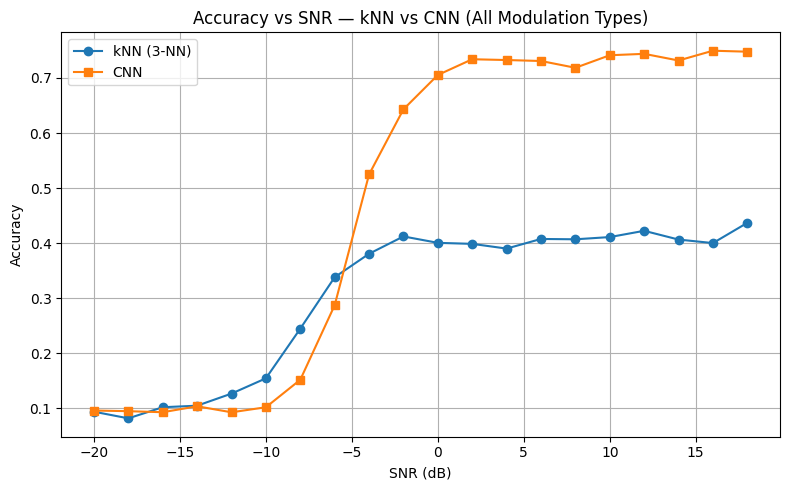

In [66]:
# CNN predictions: convert softmax to predicted class indices
y_pred_cnn = cnn_model.predict(X_test_cnn).argmax(axis=1)
y_test_encoded_flat = label_encoder.transform(y_test).ravel()

# Use y_test_encoded (integer labels from LabelEncoder)
snr_bins = sorted(np.unique(snr_test))
acc_knn_snr = []
acc_cnn_snr = []

for s in snr_bins:
    idx = np.where(snr_test == s)[0]
    if len(idx) == 0:
        acc_knn_snr.append(np.nan)
        acc_cnn_snr.append(np.nan)
        continue

    # Ensure both arrays are flat integer arrays
    acc_knn_snr.append((y_pred_knn[idx] == y_test_encoded_flat[idx]).mean())
    acc_cnn_snr.append((y_pred_cnn[idx] == y_test_encoded[idx].ravel()).mean())

# Plot
plt.figure(figsize=(8, 5))
plt.plot(snr_bins, acc_knn_snr, marker='o', label='kNN (3-NN)')
plt.plot(snr_bins, acc_cnn_snr, marker='s', label='CNN')
plt.xlabel("SNR (dB)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs SNR — kNN vs CNN (All Modulation Types)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [56]:
print("y_pred_knn shape:", y_pred_knn.shape)
print("y_test_encoded shape:", y_test_encoded.shape)
print("CNN acc:", (y_pred_cnn == y_test_encoded_flat).mean())
print("kNN acc:", (y_pred_knn == y_test_encoded_flat).mean())


y_pred_knn shape: (55000,)
y_test_encoded shape: (55000, 1)
CNN acc: 0.4771090909090909
kNN acc: 0.0


In [57]:
# Flatten the encoded test labels
y_test_encoded_flat = y_test_encoded.ravel()

# Compare unique classes
print("kNN preds:", np.unique(y_pred_knn))
print("Encoded test labels:", np.unique(y_test_encoded_flat))


kNN preds: ['8PSK' 'AM-DSB' 'AM-SSB' 'BPSK' 'CPFSK' 'GFSK' 'PAM4' 'QAM16' 'QAM64'
 'QPSK' 'WBFM']
Encoded test labels: [ 0  1  2  3  4  5  6  7  8  9 10]


In [76]:
# dense layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(dr))
model.add(Dense(len(classes)))
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
model.summary()

AttributeError: 'Functional' object has no attribute 'add'

In [ ]:
def ReLU(x):
    """Readable ReLU activation function"""
    if x < 0:
        return 0
    else:
        return x
plt.plot(np.arange(-10, 10), [ReLU(x) for x in np.arange(-10, 10)])
plt.title('ReLU')

In [ ]:
def sigmoid(x):
    """-> 0,1 = PROBABILTY"""
    return 1 / (1 + np.exp(-x))
plt.plot(np.arange(-10, 10), [sigmoid(x) for x in np.arange(-10, 10)])
plt.title('Sigmoid')

In [ ]:
def softmax(x):
    """Compute softmax values for each sets of scores in x.

    -> 0,1 = PROBABILTY"""
    return np.exp(x) / np.sum(np.exp(X))

x = np.arange(-10, 10)

softmax(x)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')


In [ ]:
# exercise: look at different epoch numbers!

history = model.fit(X_train, Y_train, epochs=50)

In [ ]:
# Show loss curves
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.legend()

In [ ]:
# Show simple version of performance

# X -> model -> Y
score = model.evaluate(X_test, Y_test)
score

In [ ]:
# train score (not a good metric)

score = model.evaluate(X_train, Y_train)
score

## SCNN Model
- Implement 1D CNN architecture in PyTorch  
- Train with cross-entropy loss and Adam optimizer  
- Track accuracy/loss curves over epochs  
- Evaluate on test set and visualize confusion matrix  
SOURCE: https://www.kaggle.com/code/mattiasgcross/cnn-tutorial-for-radioml2016#Create-the-convolutional-base
---

FR 10%
FR 20%
FR 30%
FR 40%
FR 50%
FR 60%
FR 70%
FR 80%
FR 90%
FR 100%
(154000, 16, 128)
(66000, 16, 128)
FR complete
----------------------------------------------------------------------------------------------------
Training data: (154000, 16, 128, 2)
Training labels: (154000, 11)
Testing data (66000, 16, 128, 2)
Testing labels (66000, 11)
----------------------------------------------------------------------------------------------------


Model: "SCNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 16, 128,   │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 16, 132,   │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 18, 128,   │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 8, 125,    │      2,772 │ zero_padding2d[0… │
│                     │ 84)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 125,    │      2,772 │ zero_padding2d_1… │
│                     │ 84)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 8, 125,    │          0 │ conv2d[0][0]      │
│ (Activation)        │ 84)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 8, 125,    │          0 │ conv2d_1[0][0]    │
│ (Activation)        │ 84)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 8, 125,    │        336 │ activation[0][0]  │
│ (BatchNormalizatio… │ 84)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 125,    │        336 │ activation_1[0][… │
│ (BatchNormalizatio… │ 84)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 125,    │          0 │ batch_normalizat… │
│ (Concatenate)       │ 168)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 8, 128,    │          0 │ concatenate[0][0] │
│ (ZeroPadding2D)     │ 168)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 128,    │    112,980 │ zero_padding2d_2… │
│                     │ 84)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 128,    │     84,756 │ zero_padding2d_2… │
│                     │ 84)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 8, 128,    │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 84)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 8, 128,    │          0 │ conv2d_3[0][0]    │
│ (Activation)        │ 84)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 128,    │        336 │ activation_2[0][… │
│ (BatchNormalizatio… │ 84)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 128,    │        336 │ activation_3[0][

 Total params: 10,094,579 (38.51 MB)

 Trainable params: 10,093,571 (38.50 MB)

 Non-trainable params: 1,008 (3.94 KB)

Epoch 1/100
602/602 ━━━━━━━━━━━━━━━━━━━━ 442s 668ms/step - accuracy: 0.1434 - loss: 2.3876 - val_accuracy: 0.3589 - val_loss: 1.7349 - learning_rate: 5.0000e-04
Epoch 2/100
602/602 ━━━━━━━━━━━━━━━━━━━━ 349s 579ms/step - accuracy: 0.3201 - loss: 1.7747 - val_accuracy: 0.4096 - val_loss: 1.4743 - learning_rate: 5.0000e-04
Epoch 3/100
602/602 ━━━━━━━━━━━━━━━━━━━━ 349s 579ms/step - accuracy: 0.3658 - loss: 1.5962 - val_accuracy: 0.4172 - val_loss: 1.4293 - learning_rate: 5.0000e-04
Epoch 4/100
602/602 ━━━━━━━━━━━━━━━━━━━━ 348s 578ms/step - accuracy: 0.4350 - loss: 1.4289 - val_accuracy: 0.4960 - val_loss: 1.2879 - learning_rate: 5.0000e-04
Epoch 5/100
602/602 ━━━━━━━━━━━━━━━━━━━━ 348s 578ms/step - accuracy: 0.5025 - loss: 1.2726 - val_accuracy: 0.5200 - val_loss: 1.2103 - learning_rate: 5.0000e-04
Epoch 6/100
602/602 ━━━━━━━━━━━━━━━━━━━━ 348s 578ms/step - accuracy: 0.5152 - loss: 1.2332 - val_accuracy: 0.5268 - val_loss: 1.1818 - learning_rate: 5.0000e-04
Epoch 7/100
602/602 ━━━━━━━━━━━━━━

[2.127697467803955, 1.7175236940383911, 1.5719273090362549, 1.377975344657898, 1.2634236812591553, 1.2289706468582153, 1.2108750343322754, 1.1835678815841675, 1.1572006940841675, 1.1413803100585938, 1.1331325769424438, 1.1274020671844482, 1.1239945888519287, 1.1184061765670776, 1.1168954372406006, 1.1132086515426636, 1.111289620399475, 1.107817530632019, 1.1084740161895752, 1.1054291725158691, 1.1033711433410645, 1.1011760234832764, 1.0992517471313477, 1.10161554813385, 1.097726583480835, 1.0960248708724976, 1.0948079824447632, 1.0927294492721558, 1.0892277956008911, 1.0858782529830933, 1.0823971033096313, 1.0756548643112183, 1.070802092552185, 1.0672235488891602, 1.0641858577728271, 1.0610222816467285, 1.0585341453552246, 1.055341362953186, 1.0549941062927246, 1.0496346950531006, 1.0479248762130737, 1.0450904369354248, 1.0450230836868286, 1.043924331665039, 1.0422027111053467, 1.0400433540344238, 1.038894534111023, 1.0367202758789062, 1.0398914813995361, 1.0366458892822266, 1.03216779

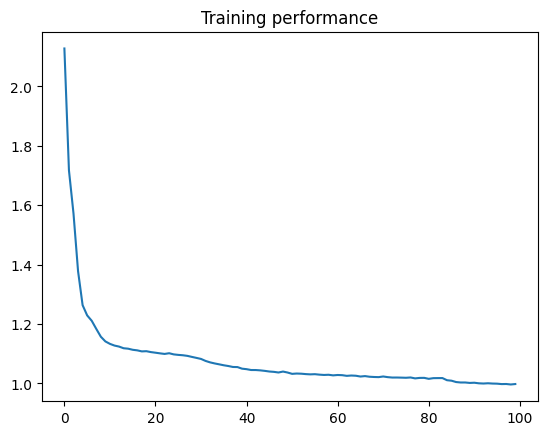

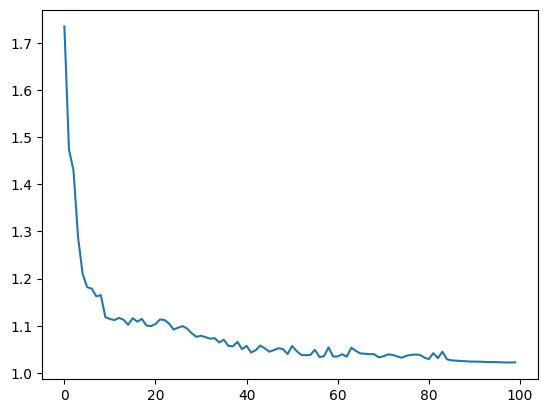

105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step


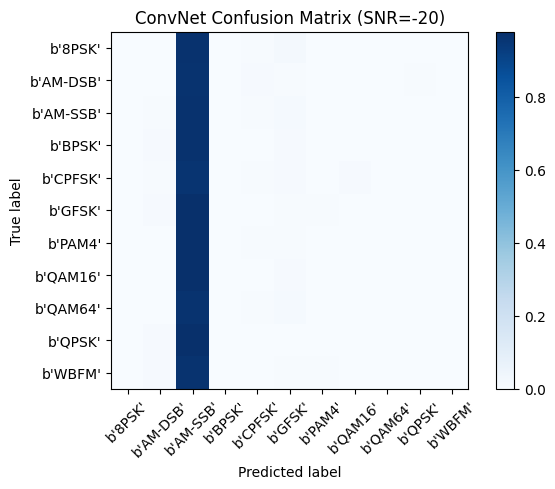

snr: -20
acc: 0.09536621823617339
103/103 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step


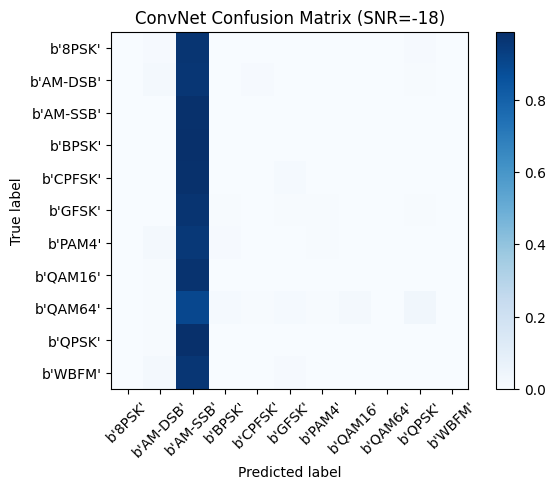

snr: -18
acc: 0.0964698721850274
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step


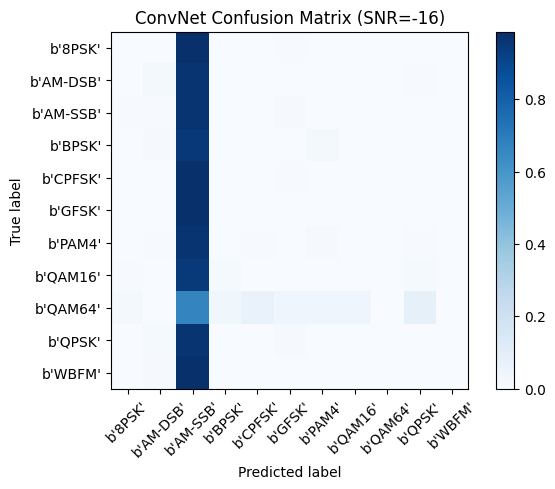

snr: -16
acc: 0.0958065503520049
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step


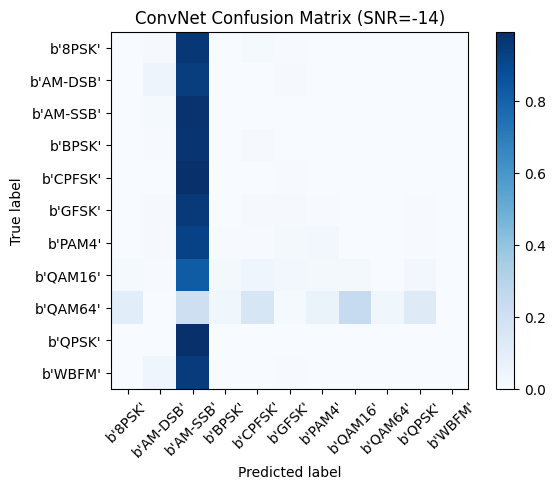

snr: -14
acc: 0.09826946847960445
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


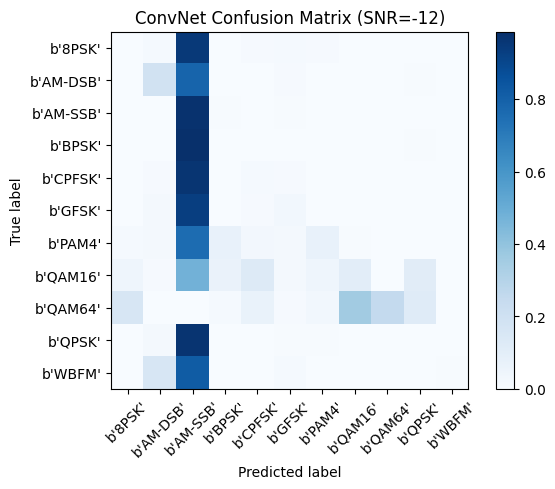

snr: -12
acc: 0.14527546937519237
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


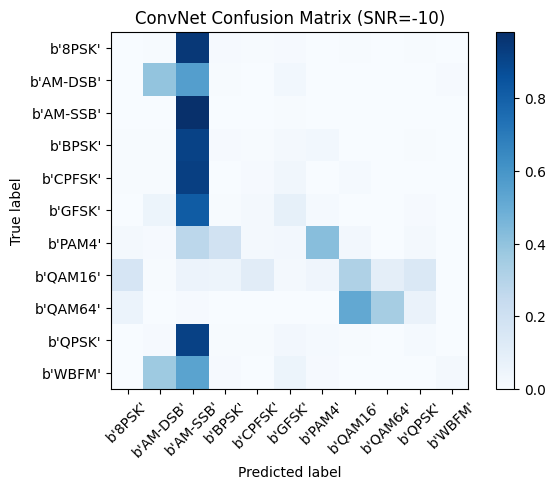

snr: -10
acc: 0.23313432835820896
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step


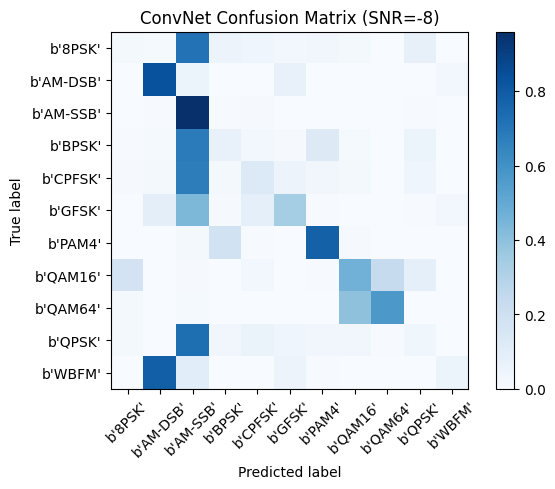

snr: -8
acc: 0.3971864711164322
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step


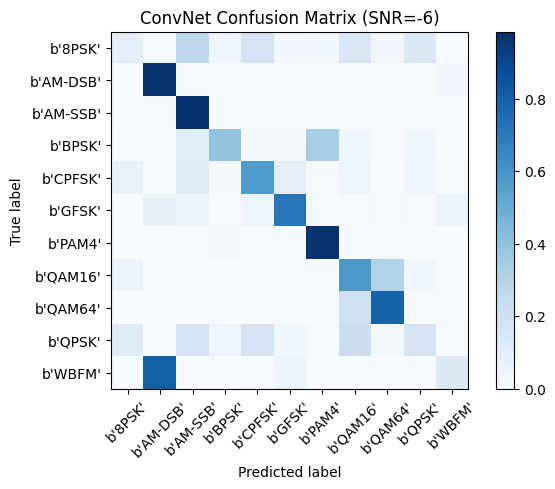

snr: -6
acc: 0.5882352941176471
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step


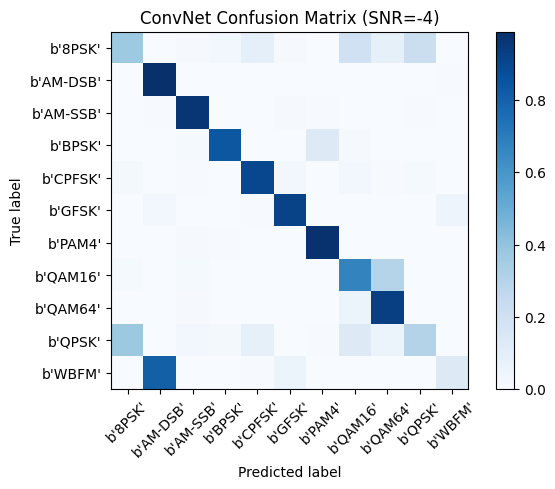

snr: -4
acc: 0.7276839565741857
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


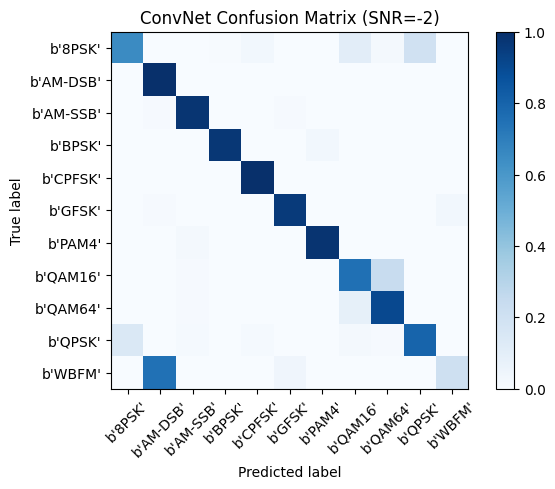

snr: -2
acc: 0.839542387797008
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step


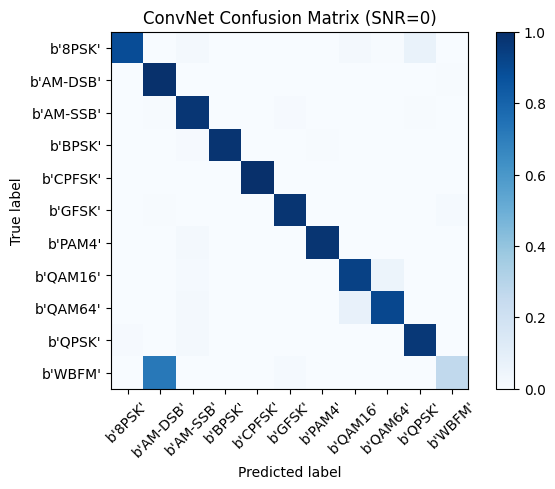

snr: 0
acc: 0.8925275379577255
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step


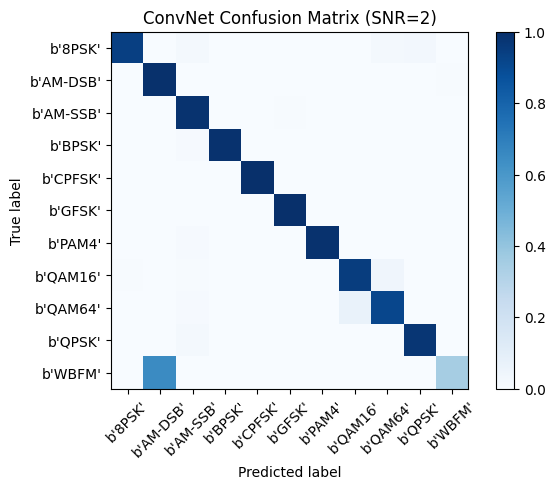

snr: 2
acc: 0.9183064997018485
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step


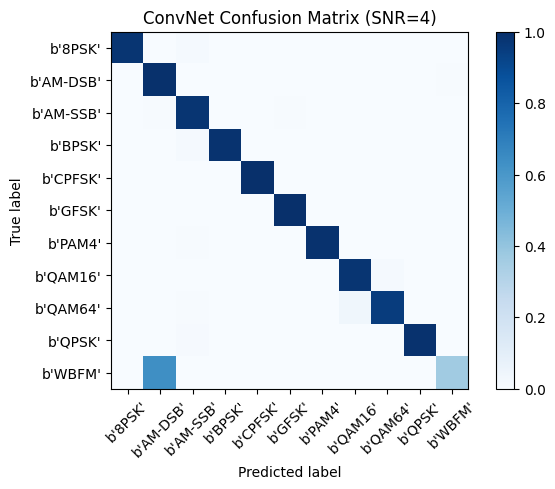

snr: 4
acc: 0.9290780141843972
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step


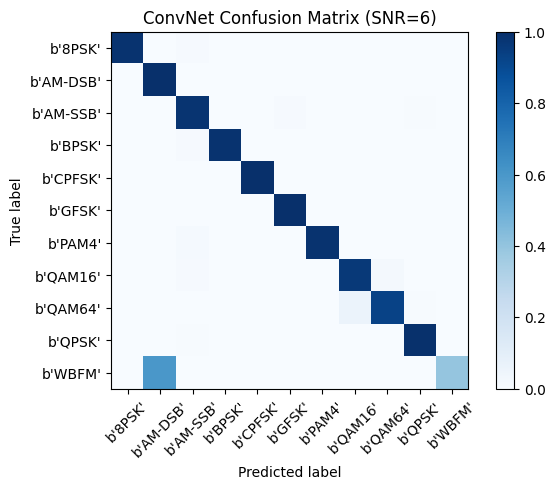

snr: 6
acc: 0.93134513824169
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step


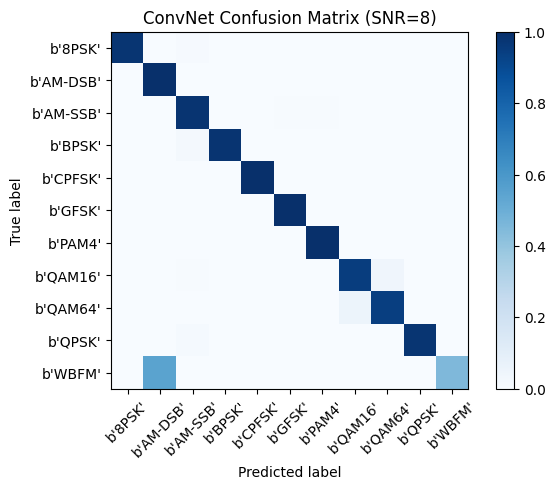

snr: 8
acc: 0.933843797856049
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step


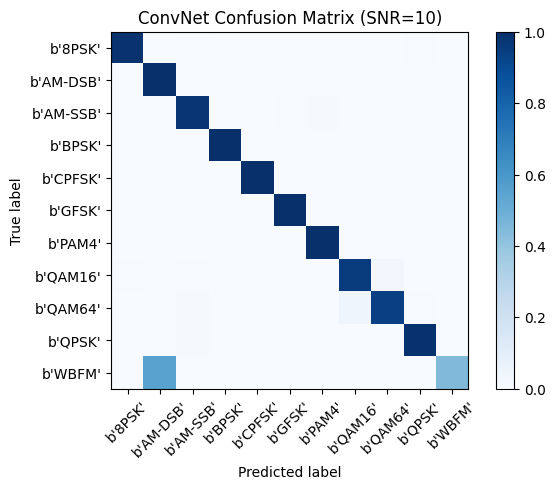

snr: 10
acc: 0.9349520383693045
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step


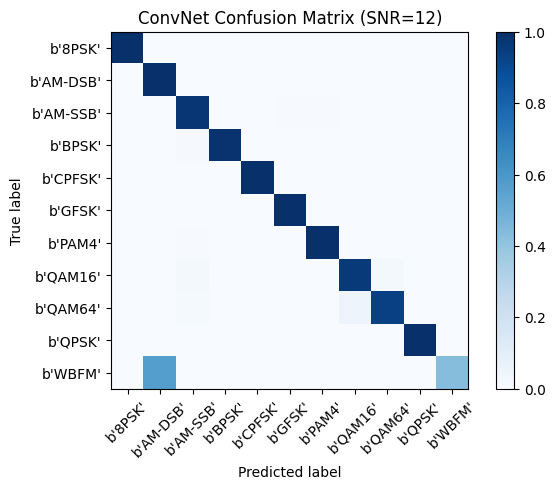

snr: 12
acc: 0.936436884512086
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


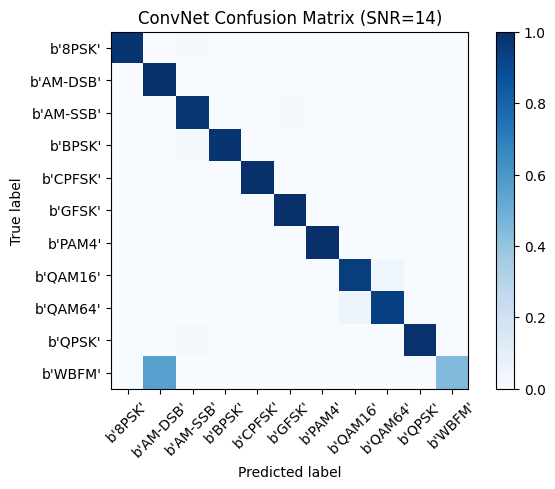

snr: 14
acc: 0.9350569405971068
103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step


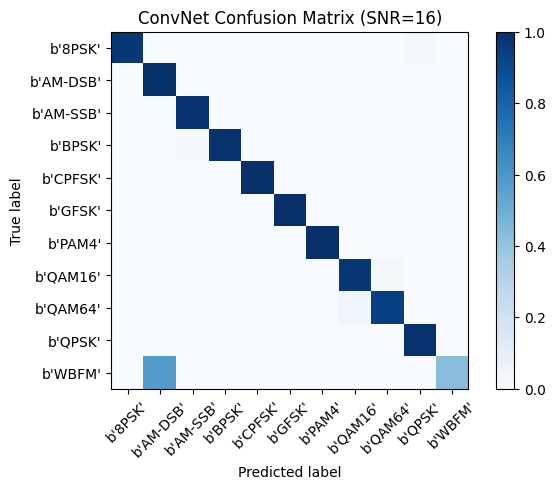

snr: 16
acc: 0.9312136961173952
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step


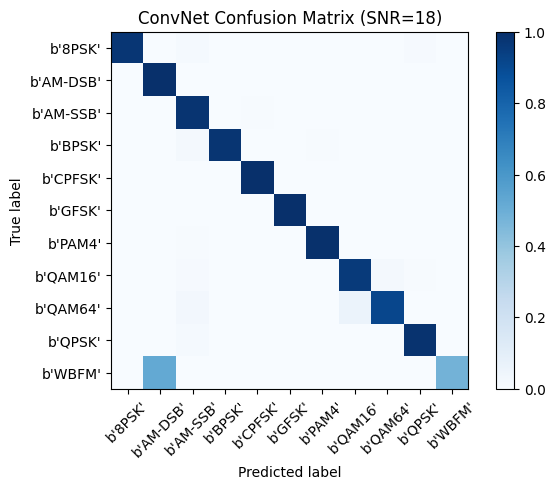

snr: 18
acc: 0.9315110565110565


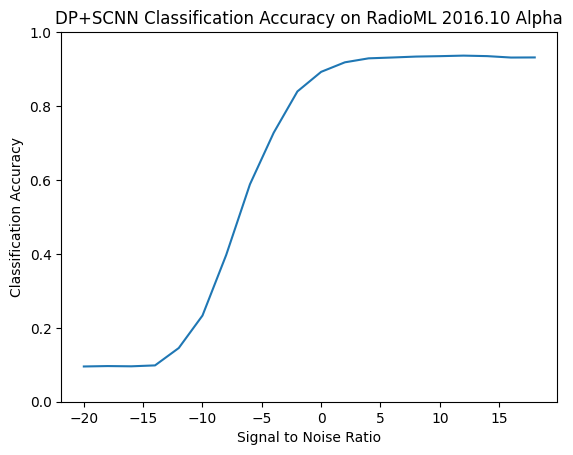

In [70]:

import numpy as np

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

import pickle


import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

snrs = ""
mods = ""
test_idx = ""
lbl = ""
ttrate = 0.7


def gendata(fp):
    global snrs, mods, test_idx, lbl
    Xd = pickle.load(open(fp, 'rb'), encoding='bytes')
    snrs, mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1, 0])
    X = []
    lbl = []

    for mod in mods:
        for snr in snrs:
            X.append(Xd[(mod, snr)])
            for i in range(Xd[(mod, snr)].shape[0]):
                lbl.append((mod, snr))
    X = np.vstack(X)

    np.random.seed(2019)
    n_examples = X.shape[0]
    n_train = int(n_examples * ttrate)
    train_idx = np.random.choice(range(0, n_examples), size=n_train, replace=False)
    test_idx = list(set(range(0, n_examples)) - set(train_idx))
    X_train = X[train_idx]
    X_test = X[test_idx]

    def to_onehot(yy):
        yy1 = np.zeros([len(yy), max(yy) + 1])
        yy1[np.arange(len(yy)), yy] = 1
        return yy1

    Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
    Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

    return (X_train, X_test, Y_train, Y_test)

def FeatureReverse(a,step):
    def Reverse(a,s):
        b = a
        i = 1
        while (1):
            p = i * (i + 1) * s / 2
            p = int(p)
            b = np.r_[b, np.c_[a[:, (len(a[0]) - p):], a[:, :(len(a[0]) - p)]]]
            i = i + 1
            if p + (i + 1) * s > len(a[0]):
                break
        return b
    ab = np.array([])
    for i in range(a.shape[0]):
        ab = np.append(ab,Reverse(a[i],step))
    ab = np.array(ab).reshape((a.shape[0], int(ab.shape[0]/(a.shape[0]*a.shape[2])), a.shape[2]))
    return ab

xtrain1, xtest1, ytrain1, ytest1 = gendata("/content/drive/MyDrive/AMC_datasets/RadioML2016_10A_dataset.pkl")

Rstep = 4
trainbatch = int(xtrain1.shape[0]/1000)   #Distributed processing to effectively increase computing speed
testbatch = int(xtest1.shape[0]/1000)
x_train1 = FeatureReverse(xtrain1[:trainbatch],Rstep)
x_test1 = FeatureReverse(xtest1[:testbatch],Rstep)
for i in range(99):
    x_train1 = np.r_[x_train1,FeatureReverse(xtrain1[(i+1)*trainbatch:(i+2)*trainbatch],Rstep)]
    x_test1 = np.r_[x_test1,FeatureReverse(xtest1[(i+1)*testbatch:(i+2)*testbatch],Rstep)]
print('FR 10%')
for i in range(100):
    x_train1 = np.r_[x_train1,FeatureReverse(xtrain1[i*trainbatch+trainbatch*100:(i+1)*trainbatch+trainbatch*100],Rstep)]
    x_test1 = np.r_[x_test1,FeatureReverse(xtest1[i*testbatch+testbatch*100:(i+1)*testbatch+testbatch*100],Rstep)]
print('FR 20%')
for i in range(100):
    x_train1 = np.r_[x_train1,FeatureReverse(xtrain1[i*trainbatch+trainbatch*100*2:(i+1)*trainbatch+trainbatch*100*2],Rstep)]
    x_test1 = np.r_[x_test1,FeatureReverse(xtest1[i*testbatch+testbatch*100*2:(i+1)*testbatch+testbatch*100*2],Rstep)]
print('FR 30%')
for i in range(100):
    x_train1 = np.r_[x_train1,FeatureReverse(xtrain1[i*trainbatch+trainbatch*100*3:(i+1)*trainbatch+trainbatch*100*3],Rstep)]
    x_test1 = np.r_[x_test1,FeatureReverse(xtest1[i*testbatch+testbatch*100*3:(i+1)*testbatch+testbatch*100*3],Rstep)]
print('FR 40%')
for i in range(100):
    x_train1 = np.r_[x_train1,FeatureReverse(xtrain1[i*trainbatch+trainbatch*100*4:(i+1)*trainbatch+trainbatch*100*4],Rstep)]
    x_test1 = np.r_[x_test1,FeatureReverse(xtest1[i*testbatch+testbatch*100*4:(i+1)*testbatch+testbatch*100*4],Rstep)]
print('FR 50%')
for i in range(100):
    x_train1 = np.r_[x_train1,FeatureReverse(xtrain1[i*trainbatch+trainbatch*100*5:(i+1)*trainbatch+trainbatch*100*5],Rstep)]
    x_test1 = np.r_[x_test1,FeatureReverse(xtest1[i*testbatch+testbatch*100*5:(i+1)*testbatch+testbatch*100*5],Rstep)]
print('FR 60%')
for i in range(100):
    x_train1 = np.r_[x_train1,FeatureReverse(xtrain1[i*trainbatch+trainbatch*100*6:(i+1)*trainbatch+trainbatch*100*6],Rstep)]
    x_test1 = np.r_[x_test1,FeatureReverse(xtest1[i*testbatch+testbatch*100*6:(i+1)*testbatch+testbatch*100*6],Rstep)]
print('FR 70%')
for i in range(100):
    x_train1 = np.r_[x_train1,FeatureReverse(xtrain1[i*trainbatch+trainbatch*100*7:(i+1)*trainbatch+trainbatch*100*7],Rstep)]
    x_test1 = np.r_[x_test1,FeatureReverse(xtest1[i*testbatch+testbatch*100*7:(i+1)*testbatch+testbatch*100*7],Rstep)]
print('FR 80%')
for i in range(100):
    x_train1 = np.r_[x_train1,FeatureReverse(xtrain1[i*trainbatch+trainbatch*100*8:(i+1)*trainbatch+trainbatch*100*8],Rstep)]
    x_test1 = np.r_[x_test1,FeatureReverse(xtest1[i*testbatch+testbatch*100*8:(i+1)*testbatch+testbatch*100*8],Rstep)]
print('FR 90%')
for i in range(100):
    x_train1 = np.r_[x_train1,FeatureReverse(xtrain1[i*trainbatch+trainbatch*100*9:(i+1)*trainbatch+trainbatch*100*9],Rstep)]
    x_test1 = np.r_[x_test1,FeatureReverse(xtest1[i*testbatch+testbatch*100*9:(i+1)*testbatch+testbatch*100*9],Rstep)]
print('FR 100%')
print(x_train1.shape)
print(x_test1.shape)
print('FR complete')

from numpy import linalg as la
def amp_phase(a):
    b = np.zeros(a.shape)
    n = int(a.shape[1]/2)
    for i in range(n):
        x_tran = a[:,i*2,:] + 1j*a[:,i*2+1,:]
        b[:,i*2,:] = np.abs(x_tran)
        b[:,i*2+1,:] = np.arctan2(a[:,i*2,:], a[:,i*2+1,:]) / np.pi
    return b
def norm(a,b):
    for i in range(a.shape[0]):
        norm_amp = 1 / la.norm(a[i, 0, :], 2)
        b[i,:,:] = b[i,:,:] * norm_amp
        for j in range(int(a.shape[1]/2)):
            a[i,j*2,:] = a[i,j*2,:] * norm_amp
    return  a,b
x_train1a = amp_phase(x_train1)
x_test1a = amp_phase(x_test1)
x_train1a,x_train1 = norm(x_train1a,x_train1)
x_test1a,x_test1 = norm(x_test1a,x_test1)
x_train1 = x_train1.reshape(x_train1.shape[0],x_train1.shape[1],x_train1.shape[2],1)
x_train1a = x_train1a.reshape(x_train1a.shape[0],x_train1a.shape[1],x_train1a.shape[2],1)
x_test1 = x_test1.reshape(x_test1.shape[0],x_test1.shape[1],x_test1.shape[2],1)
x_test1a = x_test1a.reshape(x_test1a.shape[0],x_test1a.shape[1],x_test1a.shape[2],1)

xtrain = np.concatenate((x_train1,x_train1a),axis=3)
xtest = np.concatenate((x_test1,x_test1a),axis=3)

def channeltrans(a):
    b = np.zeros(a.shape)
    for i in range(int(a.shape[1]/2)):
        b[:,i*2:i*2+2,:,:] = np.swapaxes(a[:,i*2:i*2+2,:,:],1,3)
    return b

x_train1 = channeltrans(xtrain)
x_test1 = channeltrans(xtest)

X_train = x_train1
X_test = x_test1

Y_train = ytrain1[:X_train.shape[0]]
Y_test = ytest1[:X_test.shape[0]]
test_idx = test_idx[:X_test.shape[0]]

NB_CLASSES=len(Y_train[0])

print("--" * 50)
print("Training data:", X_train.shape)
print("Training labels:", Y_train.shape)
print("Testing data", X_test.shape)
print("Testing labels", Y_test.shape)
print("--" * 50)


def getFontColor(value):
    if np.isnan(value):
        return "black"
    elif value < 0.2:
        return "black"
    else:
        return "white"

def getConfusionMatrixPlot(true_labels, predicted_labels):
    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm = np.nan_to_num(cm_norm)
    cm = np.round(cm_norm, 2)
    print(cm)

    # create figure
    fig = plt.figure()
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    res = ax.imshow(cm, cmap=plt.cm.binary,
                    interpolation='nearest', vmin=0, vmax=1)

    # add color bar
    plt.colorbar(res)

    # annotate confusion entries
    width = len(cm)
    height = len(cm[0])

    for x in range(width):
        for y in range(height):
            ax.annotate(str(cm[x][y]), xy=(y, x), horizontalalignment='center',
                        verticalalignment='center', color=getFontColor(cm[x][y]))

    # add genres as ticks
    alphabet = mods
    plt.xticks(range(width), alphabet[:width], rotation=30)
    plt.yticks(range(height), alphabet[:height])
    return plt


from keras import layers
from keras import Sequential, layers
from keras.layers import Reshape, Conv2D, Dense, Activation, Dropout, Flatten, ZeroPadding2D
from keras import optimizers
from keras import models
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, ZeroPadding2D, GlobalAveragePooling2D, Activation, Average, \
    Dropout, GaussianNoise, LSTM, GlobalMaxPooling2D, Add, BatchNormalization, Concatenate
from keras import Model
from keras import regularizers

reduce_lr = ReduceLROnPlateau(monitor='loss', patience=3, mode='auto', factor=0.01)
adam0 = optimizers.Adam(learning_rate=0.0005)

in_shp=X_train.shape[1:]

from keras import optimizers
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import *

def SCNN(input_shape, classes):
    x_input = Input(input_shape)
    x1 = ZeroPadding2D(padding=((0, 0), (0, 4)))(x_input)
    x1 = Conv2D(84, (2, 8), strides=(2, 1), padding='valid')(x1)
    x1 = Activation('relu')(x1)
    x1 = BatchNormalization()(x1)
    x2 = ZeroPadding2D(padding=((0, 2), (0, 0)))(x_input)
    x2 = Conv2D(84, (4, 4), strides=(2, 1), padding='valid')(x2)
    x2 = Activation('relu')(x2)
    x2 = BatchNormalization()(x2)
    x = Concatenate(axis=3)([x1, x2])
    x = ZeroPadding2D(padding=((0, 0), (0, 3)))(x)
    def Res_block(y):
        shortcut_unit = y
        y1 = Conv2D(84, (1, 8), padding='same')(y)
        y1 = Activation('relu')(y1)
        y1 = BatchNormalization()(y1)
        y1 = Dropout(0.5)(y1)
        y2 = Conv2D(84, (2, 3), padding='same')(y)
        y2 = Activation('relu')(y2)
        y2 = BatchNormalization()(y2)
        y2 = Dropout(0.5)(y2)
        y = Concatenate(axis=3)([y1, y2])
        y = Add()([shortcut_unit, y])
        return y
    x = Res_block(x)
    x = Res_block(x)
    x = Conv2D(168, (2, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(168, (1, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.5)(x)
    x = Conv2D(256, (2, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (2, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.5)(x)
    x = Conv2D(512, (1, 3), padding='same')(x)
    x = Dropout(0.5)(x)
    x = Activation('relu')(x)
    x = Flatten()(x)
    x = Dense(256)(x)
    x = GaussianNoise(0.01)(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(classes)(x)
    x_out = Activation('softmax')(x)
    model = Model(inputs=x_input, outputs=x_out, name='SCNN')
    return model

def CNN2(input_shape, classes):
    x_input = Input(input_shape)
    x = Conv2D(256,(4,4) , strides= (2,1) , padding='valid')(x_input)
    x = Activation('relu')(x)
    x = Conv2D(256,(3,3) , padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.6)(x)
    x = Conv2D(80,(3,3) , padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(80,(3,3) , padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.6)(x)
    x = Flatten()(x)
    x = Dense(256)(x)
    x = Activation('relu')(x)
    x = Dropout(0.6)(x)
    x = Dense(classes)(x)
    x_out = Activation('softmax')(x)
    model = Model(inputs=x_input, outputs=x_out, name='CNN2')
    return model

model = SCNN(in_shp, NB_CLASSES)
# model = CNN2(in_shp, NB_CLASSES)
model.summary()

model.compile(loss='categorical_crossentropy', optimizer=adam0, metrics=['accuracy'])

batch_size = 256
epochs = 100
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, Y_test),
                    callbacks=[reduce_lr]
                    )
#model.save('D:\\DPM+SCNN.h5')
model.save('/content/drive/MyDrive/DPM_SCNN.h5')
# model.save('D:\\DPM+CNN2.h5')
print(history.history['loss'])
print('')
print(history.history['val_loss'])
plt.figure()
plt.title('Training performance')
plt.plot(history.history['loss'], label='train loss+error')
plt.show()
plt.plot(history.history['val_loss'], label='val_error')
plt.show()
acc = {}


def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


for snr in snrs:

    # extract classes @ SNR
    test_SNRs = map(lambda x: lbl[x][1], test_idx)
    test_SNRs = list(test_SNRs)
    test_X_i = X_test[np.where(np.array(test_SNRs) == snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs) == snr)]
    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)

    conf = np.zeros([len(mods), len(mods)])
    confnorm = np.zeros([len(mods), len(mods)])
    for i in range(0, test_X_i.shape[0]):
        j = list(test_Y_i[i, :]).index(1)
        k = int(np.argmax(test_Y_i_hat[i, :]))
        conf[j, k] = conf[j, k] + 1
    for i in range(0, len(mods)):
        confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])

    plot_confusion_matrix(confnorm, labels=mods, title="ConvNet Confusion Matrix (SNR=%d)" % (snr))
    plt.show()

    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor

    acc[snr] = 1.0 * cor / (cor + ncor)
    print('snr:', snr)
    print('acc:', acc[snr])

plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("DP+SCNN Classification Accuracy on RadioML 2016.10 Alpha")
# plt.title("DP+CNN2 Classification Accuracy on RadioML 2016.10 Alpha")
plt.yticks(np.linspace(0, 1, 6))
plt.show()

In [ ]:
import numpy as np

# --- If you *don't* already have yhat_cnn from your CNN section, compute it now ---
try:
    _ = yhat_cnn  # just to check it exists
except NameError:
    import torch
    from torch.utils.data import TensorDataset, DataLoader
    # Ensure device is defined. If running on CPU, remove .to(device) later
    device = "cuda" if torch.cuda.is_available() else "cpu"
    Xte_t = torch.tensor(X_te, dtype=torch.float32)

    # Convert the numpy array of zeros to a PyTorch tensor
    dummy_labels_t = torch.tensor(np.zeros(len(Xte_t)), dtype=torch.float32)

    test_dl  = DataLoader(TensorDataset(Xte_t, dummy_labels_t), batch_size=512)
    yhat_list = []
    with torch.no_grad():
        for xb,_ in test_dl:
            # Assuming 'model' is a Keras model as in previous cells.
            # Keras models expect numpy arrays or tensorflow tensors as input by default.
            # If 'model' is a PyTorch model, uncomment the following line:
            # xb = xb.to(device)

            # If 'model' is a Keras model, convert PyTorch tensor back to numpy for prediction
            if not isinstance(model, torch.nn.Module): # Check if it's not a PyTorch model
                 xb_np = xb.cpu().numpy() # Move to CPU and convert to numpy

            # Make prediction using the model
            # If 'model' is a Keras model:
            if not isinstance(model, torch.nn.Module):
                 yhat_batch = model.predict(xb_np).argmax(axis=1) # Use predict and specify axis for argmax
            # If 'model' is a PyTorch model:
            # else:
            #     yhat_batch = model(xb).argmax(1).cpu().numpy()

            yhat_list.append(yhat_batch)

    yhat_cnn = np.concatenate(yhat_list)


# --- If your y_te is strings and your yhat_cnn is numeric, map to numeric for a fair compare ---
if isinstance(y_te[0], (str, bytes, np.str_)): # Added np.str_ to check
    # build mapping from the unique_mods list returned by load_radioml_pkl_dataset
    # Ensure keys are byte strings to match y_te if y_te contains byte strings
    # If y_te contains np.str_, convert unique_mods to np.str_
    if isinstance(y_te[0], np.str_):
         cls2id = {np.str_(mod): i for i, mod in enumerate(unique_mods)} # Use unique_mods from data loading
    else: # Assume y_te contains bytes or str
         cls2id = {mod.encode('utf-8') if isinstance(mod, str) else mod: i for i, mod in enumerate(unique_mods)} # Use unique_mods from data loading

    y_te_num = np.array([cls2id[c] for c in y_te])
else:
    # Ensure y_te is a numpy array of the correct type
    y_te_num = np.array(y_te)

# --- Per-SNR accuracy for CNN ---
snr_bins = sorted(np.unique(snr_te))
acc_cnn_snr = []
for s in snr_bins:
    idx = np.where(snr_te == s)[0]
    if len(idx) == 0:
        acc_cnn_snr.append(np.nan)
    else:
        # Ensure yhat_cnn and y_te_num are compared correctly
        acc_cnn_snr.append((yhat_cnn[idx] == y_te_num[idx]).mean())

acc_cnn_snr = np.array(acc_cnn_snr)
acc_cnn_snr[:5], snr_bins[:5]

In [ ]:
# Plot CNN per-SNR accuracy
plt.figure(figsize=(10, 6))
plt.plot(snr_bins, acc_cnn_snr, marker='o', linestyle='-', label='CNN')

plt.title('CNN Classification Accuracy vs. SNR')
plt.xlabel('SNR (dB)')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.ylim(-0.05, 1.05) # Adjust limits for better visualization of accuracy
plt.xticks(snr_bins)
plt.tight_layout()
plt.show()

In [ ]:
# Model Overlay
acc_clf_snr = []
for s in snr_bins:
    idx = np.where(snr_te == s)[0]
    if len(idx) == 0:
        acc_clf_snr.append(np.nan)
    else:
        acc_clf_snr.append((yhat_clf[idx] == y_te[idx]).mean())

plt.figure()
plt.plot(snr_bins, acc_clf_snr, marker='o', label='KNN')
plt.plot(snr_bins, acc_cnn_snr, marker='o', label='CNN')
plt.xlabel('SNR (dB)'); plt.ylabel('Accuracy')
plt.title('Accuracy vs SNR — Classical vs CNN')
plt.grid(True); plt.legend(); plt.show()

## RNN/LSTM Baseline

**Why LSTM here?** Temporal models can capture sequential dependencies in I/Q streams that a shallow CNN might miss. We feed sequences of length 128 with feature size 2 (I and Q).

**Input shape:** `(batch, seq_len=128, features=2)` with `batch_first=True`.


In [ ]:
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

device = "cuda" if torch.cuda.is_available() else "cpu"

# Prepare tensors for LSTM: (N, 128, 2)
Xtr_lstm = np.transpose(X_tr, (0, 2, 1)).astype(np.float32)
Xte_lstm = np.transpose(X_te, (0, 2, 1)).astype(np.float32)

# Label encoding
classes = sorted(np.unique(y))
cls2id = {c:i for i,c in enumerate(classes)}
ytr_num = np.array([cls2id[c] for c in y_tr], dtype=np.int64) if isinstance(y_tr[0], str) else np.array(y_tr, dtype=np.int64)
yte_num = np.array([cls2id[c] for c in y_te], dtype=np.int64) if isinstance(y_te[0], str) else np.array(y_te, dtype=np.int64)

train_dl = DataLoader(TensorDataset(torch.tensor(Xtr_lstm), torch.tensor(ytr_num)), batch_size=256, shuffle=True)
test_dl  = DataLoader(TensorDataset(torch.tensor(Xte_lstm), torch.tensor(yte_num)), batch_size=512, shuffle=False)

class LSTMNet(nn.Module):
    def __init__(self, num_classes, hidden=64, layers=1, dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(input_size=2, hidden_size=hidden, num_layers=layers, batch_first=True, dropout=dropout if layers>1 else 0.0)
        self.fc = nn.Sequential(nn.Linear(hidden, 128), nn.ReLU(), nn.Linear(128, num_classes))
    def forward(self, x):                 # x: (B, 128, 2)
        out, (h, c) = self.lstm(x)       # out: (B, 128, hidden)
        last = out[:, -1, :]             # take last timestep
        return self.fc(last)

lstm_model = LSTMNet(num_classes=len(classes), hidden=64, layers=1).to(device)
opt = optim.Adam(lstm_model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

def run_epoch_rnn(dl, train=True):
    lstm_model.train(train)
    total=correct=0; loss_sum=0.0
    for xb, yb in dl:
        xb, yb = xb.to(device), yb.to(device)
        if train: opt.zero_grad()
        logits = lstm_model(xb)
        loss = loss_fn(logits, yb)
        if train: loss.backward(); opt.step()
        loss_sum += loss.item()*len(xb)
        pred = logits.argmax(1)
        correct += (pred==yb).sum().item()
        total += len(xb)
    return loss_sum/total, correct/total

for epoch in range(8):
    tr_loss, tr_acc = run_epoch_rnn(train_dl, True)
    te_loss, te_acc = run_epoch_rnn(test_dl,  False)
    print(f"[LSTM] epoch {epoch+1:02d} | train {tr_acc:.3f} | test {te_acc:.3f}")

# Predictions
yhat_lstm = []
with torch.no_grad():
    for xb, _ in test_dl:
        yhat_lstm.append(lstm_model(xb.to(device)).argmax(1).cpu().numpy())
yhat_lstm = np.concatenate(yhat_lstm)

print(classification_report(yte_num, yhat_lstm, target_names=classes))


In [ ]:
# Per-SNR for LSTM
acc_lstm_snr = []
for s in snr_bins:
    idx = np.where(snr_te == s)[0]
    if len(idx)==0:
        acc_lstm_snr.append(np.nan)
    else:
        acc_lstm_snr.append((yhat_lstm[idx] == yte_num[idx]).mean())

import matplotlib.pyplot as plt
plt.figure()
if 'acc_clf_snr' in globals(): plt.plot(snr_bins, acc_clf_snr, marker='o', label='SVM+PCA')
plt.plot(snr_bins, acc_cnn_snr, marker='o', label='CNN')
plt.plot(snr_bins, acc_lstm_snr, marker='o', label='LSTM')
plt.xlabel('SNR (dB)'); plt.ylabel('Accuracy'); plt.title('Accuracy vs SNR — Classical vs CNN vs LSTM')
plt.grid(True); plt.legend(); plt.show()


## RNN Model
- Implement LSTM/GRU-based classifier
- Capture temporal dependencies in I/Q signals
- Train and evaluate similar to CNN
- Compare strengths/weaknesses vs CNN

* * *


In [ ]:
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

device = "cuda" if torch.cuda.is_available() else "cpu"

# Prepare tensors for LSTM: (N, 128, 2)
Xtr_lstm = np.transpose(X_tr, (0, 2, 1)).astype(np.float32)
Xte_lstm = np.transpose(X_te, (0, 2, 1)).astype(np.float32)

# Label encoding
# Use the unique classes from the filtered dataset (AM, FM)
classes_filtered = sorted(np.unique(y))
cls2id_filtered = {c:i for i,c in enumerate(classes_filtered)}
ytr_num = np.array([cls2id_filtered[c] for c in y_tr], dtype=np.int64) if isinstance(y_tr[0], str) else np.array(y_tr, dtype=np.int64)
yte_num = np.array([cls2id_filtered[c] for c in y_te], dtype=np.int64) if isinstance(y_te[0], str) else np.array(y_te, dtype=np.int64)


train_dl = DataLoader(TensorDataset(torch.tensor(Xtr_lstm), torch.tensor(ytr_num)), batch_size=256, shuffle=True)
test_dl  = DataLoader(TensorDataset(torch.tensor(Xte_lstm), torch.tensor(yte_num)), batch_size=512, shuffle=False)

class LSTMNet(nn.Module):
    def __init__(self, num_classes, hidden=64, layers=1, dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(input_size=2, hidden_size=hidden, num_layers=layers, batch_first=True, dropout=dropout if layers>1 else 0.0)
        self.fc = nn.Sequential(nn.Linear(hidden, 128), nn.ReLU(), nn.Linear(128, num_classes))
    def forward(self, x):                 # x: (B, 128, 2)
        out, (h, c) = self.lstm(x)       # out: (B, 128, hidden)
        last = out[:, -1, :]             # take last timestep
        return self.fc(last)

# Initialize LSTM model with the correct number of classes (2 for AM/FM)
lstm_model = LSTMNet(num_classes=len(classes_filtered), hidden=64, layers=1).to(device)
opt = optim.Adam(lstm_model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

def run_epoch_rnn(dl, train=True):
    lstm_model.train(train)
    total=correct=0; loss_sum=0.0
    for xb, yb in dl:
        xb, yb = xb.to(device), yb.to(device)
        if train: opt.zero_grad()
        logits = lstm_model(xb)
        loss = loss_fn(logits, yb)
        if train: loss.backward(); opt.step()
        loss_sum += loss.item()*len(xb)
        pred = logits.argmax(1)
        correct += (pred==yb).sum().item()
        total += len(xb)
    return loss_sum/total, correct/total

for epoch in range(8):
    tr_loss, tr_acc = run_epoch_rnn(train_dl, True)
    te_loss, te_acc = run_epoch_rnn(test_dl,  False)
    print(f"[LSTM] epoch {epoch+1:02d} | train {tr_acc:.3f} | test {te_acc:.3f}")

# Predictions
yhat_list = []
with torch.no_grad():
    for xb, _ in test_dl:
        yhat_list.append(lstm_model(xb.to(device)).argmax(1).cpu().numpy())
    yhat_lstm = np.concatenate(yhat_list) # Moved inside the block

# Use the filtered class names for the classification report
print(classification_report(yte_num, yhat_lstm, target_names=classes_filtered))

In [ ]:
# Per-SNR for LSTM
acc_lstm_snr = []
for s in snr_bins:
    idx = np.where(snr_te == s)[0]
    if len(idx)==0:
        acc_lstm_snr.append(np.nan)
    else:
        acc_lstm_snr.append((yhat_lstm[idx] == yte_num[idx]).mean())

import matplotlib.pyplot as plt
plt.figure()
if 'acc_clf_snr' in globals(): plt.plot(snr_bins, acc_clf_snr, marker='o', label='SVM+PCA')
plt.plot(snr_bins, acc_cnn_snr, marker='o', label='CNN')
plt.plot(snr_bins, acc_lstm_snr, marker='o', label='LSTM')
plt.xlabel('SNR (dB)'); plt.ylabel('Accuracy'); plt.title('Accuracy vs SNR — Classical vs CNN vs LSTM')
plt.grid(True); plt.legend(); plt.show()

## Hybrid CNN+RNN Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Conv1D, GlobalMaxPooling1D, LSTM, Dense, Dropout, concatenate
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt

# Prepare data shapes: CNN part can take (N, 2, 256), RNN part takes (N, 256, 2) or features from CNN
# We'll use Conv1D on the (N, 256, 2) shape as the CNN part, and then feed into LSTM
# The initial data split already provides X_tr, X_te with shape (N, 2, 256)

# Reshape for Conv1D/LSTM: (batch, channels, samples) -> (batch, samples, channels)
Xtr_hybrid = np.transpose(X_tr, (0, 2, 1)).astype(np.float32)
Xte_hybrid = np.transpose(X_te, (0, 2, 1)).astype(np.float32)

# Label encoding (using the same as for LSTM)
classes_filtered = sorted(np.unique(y))
cls2id_filtered = {c:i for i,c in enumerate(classes_filtered)}
ytr_num = np.array([cls2id_filtered[c] for c in y_tr], dtype=np.int64) if isinstance(y_tr[0], str) else np.array(y_tr, dtype=np.int64)
yte_num = np.array([cls2id_filtered[c] for c in y_te], dtype=np.int64) if isinstance(y_te[0], str) else np.array(y_te, dtype=np.int64)


# Define the Hybrid Model using Keras Functional API
input_shape = (Xtr_hybrid.shape[1], Xtr_hybrid.shape[2]) # (256, 2)

inputs = Input(shape=input_shape)

# CNN Branch (Conv1D)
conv1 = Conv1D(filters=64, kernel_size=8, activation='relu', padding='same')(inputs)
dropout1 = Dropout(0.5)(conv1)
conv2 = Conv1D(filters=128, kernel_size=8, activation='relu', padding='same')(dropout1)
dropout2 = Dropout(0.5)(conv2)
# Use GlobalMaxPooling1D to reduce the time dimension after CNN layers
cnn_out = GlobalMaxPooling1D()(dropout2) # Output shape: (batch, 128)

# Reshape input for LSTM (if needed, but GlobalMaxPooling1D reduces sequence length)
# Alternatively, could use Flatten() and then Dense layers before LSTM if we don't use GlobalMaxPooling1D
# Let's feed the pooled CNN features into Dense layers before the final classification

# LSTM Branch (operates on the original sequence or features)
# For a hybrid model, often the LSTM processes the features *after* the CNN
# Let's feed the output of the Conv1D layers (before pooling) into the LSTM
# This requires keeping the sequence dimension after Conv1D
conv_lstm_input = Conv1D(filters=64, kernel_size=8, activation='relu', padding='same')(inputs) # Example: another Conv1D branch feeding LSTM
dropout_lstm = Dropout(0.5)(conv_lstm_input)
lstm_out = LSTM(64, return_sequences=False)(dropout_lstm) # return_sequences=False for final output
dropout_lstm_out = Dropout(0.5)(lstm_out) # Output shape: (batch, 64)

# Concatenate outputs from CNN and LSTM branches
# Let's modify the CNN branch to also output a sequence for concatenation before LSTM
# Redefine the model to feed CNN features into LSTM

inputs = Input(shape=input_shape) # (256, 2)

# CNN Feature Extractor
conv_features = Conv1D(filters=64, kernel_size=8, activation='relu', padding='same')(inputs)
conv_features = Dropout(0.5)(conv_features)
conv_features = Conv1D(filters=128, kernel_size=8, activation='relu', padding='same')(conv_features)
conv_features = Dropout(0.5)(conv_features)
# Output shape of conv_features: (batch, 256, 128)

# LSTM part processing CNN features
lstm_out = LSTM(64, return_sequences=False)(conv_features) # Process sequence of CNN features
lstm_out = Dropout(0.5)(lstm_out) # Output shape: (batch, 64)

# Dense layers for classification
dense1 = Dense(128, activation='relu')(lstm_out)
dropout_dense = Dropout(0.5)(dense1)
outputs = Dense(len(classes_filtered), activation='softmax')(dropout_dense)

hybrid_model = Model(inputs=inputs, outputs=outputs)

hybrid_model.summary()

In [ ]:
# Compile the Hybrid Model
hybrid_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Train the Hybrid Model
# Use ytr_num which is already numeric labels
history_hybrid = hybrid_model.fit(Xtr_hybrid, ytr_num, epochs=20, batch_size=256, validation_split=0.1) # Added validation split

In [ ]:
# Evaluate the Hybrid Model
loss_hybrid, accuracy_hybrid = hybrid_model.evaluate(Xte_hybrid, yte_num)
print(f"Hybrid Model Test Accuracy: {accuracy_hybrid:.4f}")

# Generate predictions
yhat_hybrid = hybrid_model.predict(Xte_hybrid).argmax(axis=1)

# Classification Report
print(classification_report(yte_num, yhat_hybrid, target_names=classes_filtered))

In [ ]:
# Per-SNR accuracy for Hybrid Model
acc_hybrid_snr = []
for s in snr_bins:
    idx = np.where(snr_te == s)[0]
    if len(idx)==0:
        acc_hybrid_snr.append(np.nan)
    else:
        # Ensure yhat_hybrid and yte_num are compared correctly
        acc_hybrid_snr.append((yhat_hybrid[idx] == yte_num[idx]).mean())

# Plotting comparison with Hybrid model
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
if 'acc_clf_snr' in globals(): plt.plot(snr_bins, acc_clf_snr, marker='o', linestyle='--', label='KNN')
if 'acc_cnn_snr' in globals(): plt.plot(snr_bins, acc_cnn_snr, marker='o', linestyle='--', label='CNN')
if 'acc_lstm_snr' in globals(): plt.plot(snr_bins, acc_lstm_snr, marker='o', linestyle='--', label='LSTM')
plt.plot(snr_bins, acc_hybrid_snr, marker='o', linestyle='-', label='Hybrid CNN+RNN')

plt.xlabel('SNR (dB)'); plt.ylabel('Accuracy'); plt.title('Accuracy vs SNR — Model Comparison')
plt.grid(True); plt.legend(); plt.ylim(-0.05, 1.05); plt.xticks(snr_bins)
plt.tight_layout()
plt.show()

## Results & Analysis
- Present accuracy table across models
- Confusion matrices for each method
- (Optional) Accuracy vs. SNR plot
- Discuss performance trade-offs
- **Note on Analog Modulations:** The analysis focuses on a simplified set of analog modulations ('AM' and 'FM') where 'DSB-AM' and 'SSB-AM' from the original dataset are grouped under 'AM'. The dataset also has an imbalance in the number of samples per class (e.g., more 'AM' samples than 'FM' samples), which can impact model performance and confusion between classes.

* * *

## Conclusion
- Summarize findings and best-performing model
- Highlight limitations of dataset and methods
- Suggest future extensions (e.g., transformers, larger datasets, real RF data)

* * *

## References
- O’Shea et al., “RadioML Datasets,” DeepSig, 2016
- Zhang et al., *IEEE Comm. Letters*, 2021
- Guo et al., *IEEE IoT Journal*, 2024
- Huynh-The et al., *IEEE Access*, 2021

### Confusion Matrices

In [25]:
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix', labels=None): # Added optional labels argument
    """Plots a confusion matrix."""
    # Pass the explicit numeric labels [0, 1] to confusion_matrix to ensure correct size
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1]) # Explicitly use labels 0 and 1
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=.5, linecolor='black')
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

In [28]:
# Confusion Matrix for KNN
# Convert yhat_clf (string labels) to numeric labels using cls2id_filtered
yhat_clf_num = np.array([cls2id_filtered[c] for c in yhat_clf])

plot_confusion_matrix(yte_num, yhat_clf_num, classes=classes_filtered, title='Confusion Matrix - KNN')

NameError: name 'yhat_clf' is not defined

In [ ]:
# Confusion Matrix for CNN
# Need to get numeric true labels for CNN comparison
# y_te_num is already calculated in the per-SNR CNN cell (e.g., cac625ee)

# Pass yte_num as labels to ensure confusion matrix is 2x2
plot_confusion_matrix(yte_num, yhat_cnn, classes=classes_filtered, title='Confusion Matrix - CNN')

In [ ]:
# Confusion Matrix for LSTM
# yte_num and yhat_lstm are already calculated in the LSTM training cell (e.g., 64a089c4)

# Pass yte_num as labels to ensure confusion matrix is 2x2
plot_confusion_matrix(yte_num, yhat_lstm, classes=classes_filtered, title='Confusion Matrix - LSTM', labels=yte_num)

In [ ]:
# Confusion Matrix for Hybrid CNN+RNN
# yte_num and yhat_hybrid are already calculated in the Hybrid training cell (e.g., 94e398c0)

# Pass yte_num as labels to ensure confusion matrix is 2x2
plot_confusion_matrix(yte_num, yhat_hybrid, classes=classes_filtered, title='Confusion Matrix - Hybrid CNN+RNN', labels=yte_num)

## Next Steps

- Summarize key results.
- List open issues/TODOs.
- Link to references and further reading.